In [1]:
from typing import Tuple, List
import numpy as np
import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression

In [28]:
class ReLU:
    def __init__(self, alpha: float = 0.01) -> None:
        self.alpha = alpha

    def forward(self, X: np.ndarray) -> np.ndarray:
        return np.where(X > 0, X, self.alpha * X)

    def __call__(self, X: np.ndarray) -> np.ndarray:
        return self.forward(X)

    def backward(self, X: np.ndarray, grad: np.ndarray) -> np.ndarray:
        return grad * np.where(X > 0, 1, self.alpha)


class LinearLayer:
    def __init__(self, in_features: int, out_features: int, learning_rate: float) -> None:
        # He initialization
        std = np.sqrt(2 / (in_features))
        self.W = np.random.randn(in_features, out_features) * std
        self.b = np.zeros(out_features)
        self.lr = learning_rate

    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        Performs a forward pass through the layer.

        Args:
            X (np.ndarray): The input data array.

        Returns:
            np.ndarray: Predicted output array.
        """
        return X @ self.W + self.b

    def __call__(self, X: np.ndarray) -> np.ndarray:
        return self.forward(X)

    def backward(self, X: np.ndarray, grad: np.ndarray) -> np.ndarray:
        """
        Perform backward pass to compute gradients of weights and biases.

        Args:
            X (np.ndarray): Input data array.
            grad (np.ndarray): Gradient array from next layer, used to compute
                gradients for weights and biases.

        Returns:
            np.ndarray: X gradient in the current layer.
        """
        self.W -= self.lr * X.T @ grad
        self.b -= self.lr * grad.mean(axis=0)

        return grad @ self.W.T


class MLPRegressor:
    def __init__(
        self,
        input_layer_size: int,
        hidden_layer_sizes: Tuple[int] = (100,),
        learning_rate: float = 0.001,
        max_iter: int = 10,
    ) -> None:
        self.lr = learning_rate
        self.max_iter = max_iter

        self.layer_outputs = None
        in_layer = LinearLayer(
            input_layer_size, hidden_layer_sizes[0], learning_rate=self.lr
        )
        out_layer = LinearLayer(hidden_layer_sizes[-1], 1, learning_rate=self.lr)
        self.layers = [in_layer]
        for i in range(len(hidden_layer_sizes)):
            self.layers.append(ReLU())
            if i == len(hidden_layer_sizes) - 1:
                self.layers.append(out_layer)
            else:
                layer_size_in = hidden_layer_sizes[i]
                layer_size_out = hidden_layer_sizes[i + 1]
                self.layers.append(
                    LinearLayer(layer_size_in, layer_size_out, learning_rate=self.lr)
                )

    @staticmethod
    def _mse_loss(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """Calculate the MSE loss between true and predicted values.

        Args:
        y_true (np.ndarray): The ground truth target values.
        y_pred (np.ndarray): The predicted values.

        Returns:
        float: The mean squared error loss score.
        """
        return ((y_pred - y_true) ** 2).mean()

    @staticmethod
    def _mse_loss_grad(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        """Calculate the gradient of the MSE loss.

        Args:
            y_true (np.ndarray): The ground truth target values.
            y_pred (np.ndarray): The predicted values.

        Returns:
            np.ndarray: The loss gradient.
        """
        return 2 * (y_pred - y_true)

    def forward(self, X: np.ndarray) -> np.ndarray:
        """Forward pass through the network.

        Args:
            X (np.ndarray): The input data array.

        Returns:
            np.ndarray: Predicted output of the network.
        """
        output = X.copy()
        self.layer_outputs = []
        for layer in self.layers:
            output = layer(output)
            self.layer_outputs.append(output)
        return output

    def train(self, X: np.ndarray, y: np.ndarray, batch_size: int = 64) -> List[float]:
        """
        Train the neural network model on the provided data.

        Parameters:
        X (np.ndarray): The input data to train on.
        y (np.ndarray): The target labels for the training data.
        batch_size (int): The batch size to use during training. Defaults to 64.

        Returns:
        List[float]: The losses per epoch during training.
        """
        n_batches = int(X.shape[0] / batch_size)
        X_batches = np.array_split(X, n_batches)
        y_batches = np.array_split(y, n_batches)
        pbar = tqdm.tqdm(range(self.max_iter), total=self.max_iter)
        epoch_losses = []
        for _ in pbar:
            losses = []
            for X_batch, y_batch in zip(X_batches, y_batches):
                output = self.forward(X_batch)
                layer_inputs = [X_batch] + self.layer_outputs
                gradient = self._mse_loss_grad(y_batch, output)
                for i, layer in reversed(list(enumerate(self.layers))):
                    gradient = layer.backward(layer_inputs[i], gradient)
                losses.append(self._mse_loss(y_batch, output))
            pbar.set_description(f"Loss: {np.mean(losses)}")
            epoch_losses.append(np.mean(losses))

        return epoch_losses

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Make prediction for the X input data.

        Parameters
        X (np.ndarray): The input data array.

        Returns
        np.ndarray: Predicted data.
        """
        return self.forward(X)

Создадим исскуственный регрессионный датасет для тестирования написанной полносвязной сети:

In [3]:
X, y = make_regression(n_samples=100_000, n_features=10, noise=1, random_state=42)

Визуализируем распределение целевой переменной:

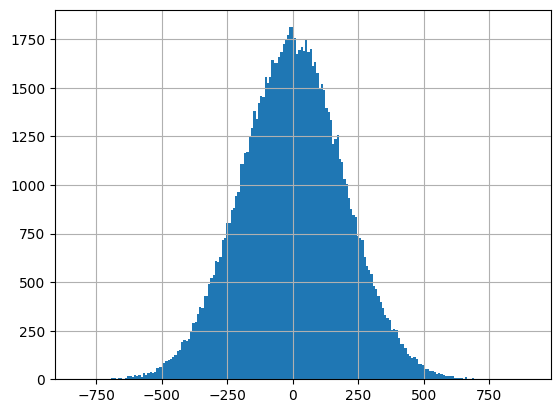

In [4]:
plt.hist(y, bins=200)
plt.grid()
plt.show()

Разобьем данные на обучение и валидацию:

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

Запустим обучение:

In [18]:
np.random.seed(42)

In [60]:
model = MLPRegressor(
    input_layer_size=X_train.shape[1],
    hidden_layer_sizes=(50, 75, 100),
    learning_rate=5e-7,
    max_iter=40,
)
losses = model.train(X_train, y_train, batch_size=32)

Loss: 1.2965500300349917: 100%|██████████| 40/40 [00:13<00:00,  3.02it/s]


Визуализируем график лосса на обучении:

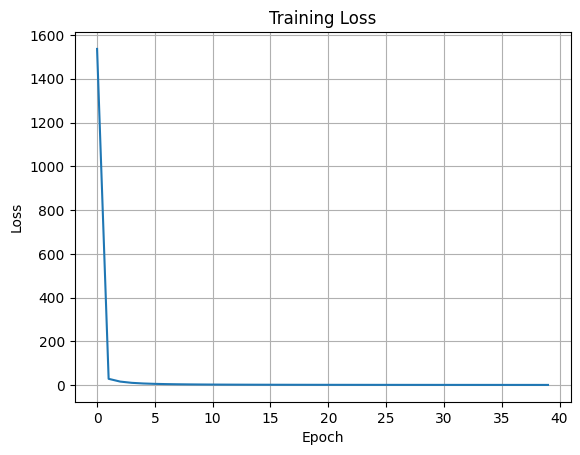

In [61]:
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()

Визуализируем распределения целевой тестовой переменной и предсказанной:

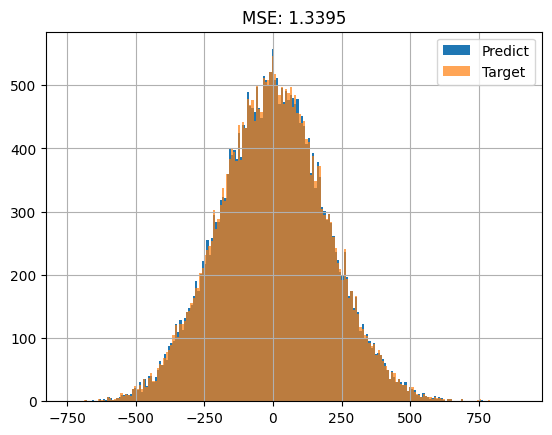

In [62]:
y_pred = model.predict(X_test)
plt.hist(y_pred.reshape(1, -1).squeeze(), bins=200, label='Predict')
plt.hist(y_test.reshape(1, -1).squeeze(), bins=200, label='Target', alpha=0.7)
plt.title(f"MSE: {MLPRegressor._mse_loss(y_test, y_pred):.4f}")
plt.legend()
plt.grid()
plt.show()

Ну, вроде, имплементация рабочая:)